In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule
import time

config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 128

In [2]:
tag_dep_seq_sent = TextGraphType.SENTIMENT
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=False, num_data_load = 200, device='cpu', batch_size=batch_size, graph_type=tag_dep_seq_sent, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()


self.num_data_load: 200
i: 0


e:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence\Scripts\DataManager\GraphConstructor\TagDepTokenGraphConstructor.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  data['sentence'].x = torch.tensor(sentence_embeddings, dtype=torch.float32)


i: 100


In [3]:
# check the huge size of sentiment files
# data_manager.graph_constructors[tag_dep_seq_sent].get_first()['sentiment'].x.shape
# data_manager.graph_constructors[tag_dep_seq_sent].get_graph(30)['sentiment' , 'sentiment_word' , 'word'].edge_index
data_manager.graph_constructors[tag_dep_seq_sent].get_first()

HeteroData(
  dep={
    length=45,
    x=[45],
  },
  tag={
    length=50,
    x=[50],
  },
  word={ x=[104, 300] },
  sentence={ x=[4, 300] },
  general={ x=[1, 300] },
  sentiment={ x=[2, 300] },
  (dep, dep_word, word)={
    edge_index=[2, 100],
    edge_attr=[100],
  },
  (word, word_dep, dep)={
    edge_index=[2, 100],
    edge_attr=[100],
  },
  (tag, tag_word, word)={
    edge_index=[2, 104],
    edge_attr=[104],
  },
  (word, word_tag, tag)={
    edge_index=[2, 104],
    edge_attr=[104],
  },
  (word, seq, word)={
    edge_index=[2, 206],
    edge_attr=[206],
  },
  (general, general_sentence, sentence)={
    edge_index=[2, 4],
    edge_attr=[4],
  },
  (sentence, sentence_general, general)={
    edge_index=[2, 4],
    edge_attr=[4],
  },
  (word, word_sentence, sentence)={
    edge_index=[2, 104],
    edge_attr=[104],
  },
  (sentence, sentence_word, word)={
    edge_index=[2, 104],
    edge_attr=[104],
  },
  (word, word_sentiment, sentiment)={
    edge_index=[2, 5],
    edge

In [9]:
data_manager.graph_constructors[TextGraphType.SENTIMENT].get_graph(20)['sentiment' , 'sentiment_word' , 'word'].edge_index

tensor([[  1,   1,   1,   1,   1,   1,   0,   0,   1,   1,   1,   1,   1],
        [  4,  21,  22,  49,  57, 106, 107, 111, 147, 156, 157, 164, 176]],
       dtype=torch.int32)

In [4]:
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))
# X1.metadata()
len(t_dataloader)

257

In [5]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, BatchNorm, SAGEConv, PairNorm
from torch_geometric.utils import to_dense_adj, dropout_path
class HeteroGCNConv(nn.Module):
    def __init__(self, in_feature, out_feature, dropout = 0.2, num_heads: int = 1) -> None:
        super().__init__()
        self.conv1 = GATv2Conv(in_feature, int(out_feature/num_heads), heads=num_heads, edge_dim=1, add_self_loops=False)
        self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        # self.dropout_rate = dropout

    def forward(self, x: Tensor, edge_index: Tensor, edge_weights: Tensor) -> Tensor:

        x = self.conv1(x, edge_index, edge_weights)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        # dropout_path(edge_index, self.dropout_rate)
        return x

class HeteroLinear(nn.Module):
    def __init__(self, in_feature, out_feature, dropout = 0.2) -> None:
        super().__init__()
        self.linear = nn.Linear(in_feature, out_feature)
        self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        # self.dropout_rate = dropout

    def forward(self, x: Tensor) -> Tensor:

        x = self.linear(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        # dropout_path(edge_index, self.dropout_rate)
        return x

In [ ]:
# from torch_geometric.nn import to_hetero
# hetero_model = to_hetero(HeteroGCNConv(300, 1024, 0.2), X2.metadata())
# pre = hetero_model(X2.x_dict, X2.edge_index_dict, X2.edge_attr_dict)

In [6]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
import torch
from typing import Dict
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm, global_mean_pool, global_add_pool, global_max_pool, MemPooling, SAGEConv, to_hetero, HeteroBatchNorm, MeanSubtractionNorm, PairNorm, HeteroConv
from torch_geometric.nn import Sequential as GSequential
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.data import HeteroData
class HeteroGcnGatModel1(torch.nn.Module):
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1):

        super(HeteroGcnGatModel1, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.bsh: int = hidden_feature
        bsh2: int = int(self.bsh/2)
        bsh4: int = int(self.bsh/4)
        bsh8: int = int(self.bsh/8)

        self.part_weight_norm = torch.nn.LayerNorm((11,))
        self.norm = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.lin1 = to_hetero(HeteroLinear(input_feature, self.bsh, dropout), X2.metadata())
        
        self.conv1 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout, num_heads=2), metadata)
        self.conv2 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout, num_heads=2), metadata)
        self.conv3 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout, num_heads=2), metadata)
        
        self.lin2 = to_hetero(HeteroLinear(self.bsh, input_feature, dropout), X2.metadata())
        
        self.mem_pool = MemPooling(self.bsh, self.bsh, 2, 1)
        
        
        self.fn1 = Linear(self.bsh, 64)
        self.fn2 = Linear(64, 64)
        self.fn3 = Linear(64, 64)
        
        self.output_layer = Linear(64, self.num_out_features)

        self.dep_embedding = torch.nn.Embedding(45, 300)
        self.tag_embedding = torch.nn.Embedding(50, 300)
        self.dep_unembedding = torch.nn.Linear(300, 45)
        self.tag_unembedding = torch.nn.Linear(300, 50)
        
        self.pw1 = torch.nn.Parameter(torch.randn([11,], dtype=torch.float32), requires_grad=True)
        self.pw2 = torch.nn.Parameter(torch.randn([11,], dtype=torch.float32), requires_grad=True)


    def forward(self, x: HeteroData) -> Tensor:
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        
        x_dict = self.lin1(x_dict)
        
        x_dict = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        x_dict = self.normalize(x_dict, x)
        
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw2)
        
        x_dict = self.conv2(x_dict, edge_index_dict, edge_attr_dict)
        x_dict = self.normalize(x_dict, x)

        x_dict = self.conv3(x_dict, edge_index_dict, edge_attr_dict)
        
        x_pooled, S = self.mem_pool(x_dict['word'], x['word'].batch)
        
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = self.fn1(x_pooled)
        x_pooled = self.fn2(x_pooled)
        x_pooled = self.fn3(x_pooled)
        out = self.output_layer(x_pooled)
        x_dict = self.lin2(x_dict)
        x_dict['dep'] = self.dep_unembedding(x_dict['dep'])
        x_dict['tag'] = self.tag_unembedding(x_dict['tag'])
        return out, x_dict

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict
        # shape1 = edge_index_dict[('sentence', 'sentence_word', 'word')].shape[1]
        # shape2 = edge_attr_dict[('word', 'word_sentence', 'sentence')].shape[0]
        # if shape1 != shape2:
        #     edge_attr_dict[('sentence', 'sentence_word', 'word')] = edge_attr_dict[('word', 'word_sentence', 'sentence')][shape1:shape2]
        #     edge_attr_dict[('word', 'word_sentence', 'sentence')] = edge_attr_dict[('word', 'word_sentence', 'sentence')][:shape1]

        for key in x.edge_attr_dict:
            edge_attr_dict[key] = self.get_scale_same(1.0, edge_attr_dict[key])

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x):
        # for key in x_dict:
        #     x_dict[key] = self.norm(x_dict[key], x[key].batch)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        self.part_weight_norm(part_weights)
        part_weights = F.relu(part_weights)
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr == None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict


    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes == None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

In [7]:
torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 64, dropout=0.2)
torch_model = torch_model.to(device)
print(next(iter(torch_model.parameters())).device)
print(torch_geometric.nn.summary(torch_model, X1.to(device)))

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


cuda:0
+------------------------------------------------------------+----------------------------------+-----------------------------+----------+
| Layer                                                      | Input Shape                      | Output Shape                | #Param   |
|------------------------------------------------------------+----------------------------------+-----------------------------+----------|
| HeteroGcnGatModel1                                         | [25032, 25032]                   | [128, 1]                    | 590,422  |
| ├─(part_weight_norm)LayerNorm                              | [11]                             | [11]                        | 22       |
| ├─(norm)PairNorm                                           | --                               | --                          | --       |
| ├─(drop)Dropout                                            | --                               | --                          | --       |
| ├─(lin1)GraphModul

In [8]:
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLossArgs, HeteroLoss1
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [9]:
x_dict_keys = X1.x_dict.keys()
print(len(list(X1.edge_attr_dict.keys())))
x_dict_keys-'word'
print(X1['word' , 'word_sentiment' , 'sentiment'].edge_index.shape)
print(X1['word' , 'word_sentiment' , 'sentiment'].edge_attr.shape)
print(X1['word'].x.shape)
print(X1['sentiment'].x.shape)
print(X1['word'].x.shape)

11
torch.Size([2, 917])
torch.Size([917])
torch.Size([11802, 300])
torch.Size([256, 300])
torch.Size([11802, 300])


In [ ]:
# step_size = 5000
# for i in range(0, 110000, step_size):
#     print(f'{i}, {i+step_size}')
#     data_manager.create_sub_data_loader(i, i+step_size)
#     # t_dataloader = data_manager2.train_dataloader()
#     # v_dataloader = data_manager2.val_dataloader()
#     # X1, y1 = next(iter(t_dataloader))
#     # X2, y2 = next(iter(v_dataloader))
    
#     callbacks = [
#         ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
#         # EarlyStopping(patience=50, mode='max', monitor='val_acc')
#     ]
#     torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 64, dropout=0.3)
#     torch_model = torch_model.to(device)
#     lightning_model = HeteroBinaryLightningModel(torch_model,
#                                                  torch.optim.Adam(torch_model.parameters(), lr=0.0046, weight_decay=0.001),
#                                         loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.005),
#                                         learning_rate=0.0046,
#                                         batch_size=batch_size,
#                                         user_lr_scheduler=False,
#                                         min_lr=0.0001
#                                         ).to(device)
#     model_manager = ClassifierModelManager(torch_model, lightning_model, model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs', log_name='test_data_1', device=device, num_train_epoch=10)
#     model_manager.fit(datamodule=data_manager)
#     model_manager.save_plot_csv_logger(name_prepend=f'{i}, {i+step_size}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])
#     # X1.metadata()
    

In [10]:
callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
    # EarlyStopping(patience=50, mode='max', monitor='val_acc')
]
lightning_model = HeteroBinaryLightningModel(torch_model,
                                 torch.optim.Adam(torch_model.parameters(), lr=0.0046, weight_decay=0.001),
                                       loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.05),
                                       learning_rate=0.0046,
                                       batch_size=batch_size,
                                       user_lr_scheduler=False,
                                       min_lr=0.0001
                                       ).to(device)
model_manager = ClassifierModelManager(torch_model, lightning_model, model_save_dir=r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs', log_name='hetero_model_2', device=device, num_train_epoch=500)

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 64, dropout=0.2)
# torch_model = torch_model.to(device)
# print(next(iter(torch_model.parameters())).device)
# print(torch_geometric.nn.summary(torch_model, X1.to(device)))
# y_a, x_dict_a = lightning_model(X1.to(device))

In [ ]:
# X1.x_dict.keys()

In [ ]:
# X1 = X1.to(device)
# y1 = y1.to(device)
# hetero_out = lightning_model(X1)
# pred_args = HeteroLossArgs(hetero_out[0], hetero_out[1])
# main_args = HeteroLossArgs(y1.view(hetero_out[0].shape), X1.x_dict)
# hetero_loss_func = HeteroLoss1(exception_keys=['word'])
# hetero_loss_func(pred_args, main_args)

In [ ]:
# model_manager.tune(data_manager=data_manager, min_lr=1e-5, max_lr = 1e-2)

In [11]:
model_manager.fit(datamodule=data_manager)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 590 K 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
590 K     Trainable params
0         Non-trainable params
590 K     Total params
2.362     Total estimated model params size (MB)
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441

Epoch 42:  22%|██▏       | 57/257 [00:16<00:58,  3.42it/s, v_num=9, train_acc_step=0.836, val_acc_step=0.892, val_acc_epoch=0.871, train_acc_epoch=0.856] 

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model_manager.lightning_model.loss_func = HeteroLoss1(exception_keys=['word'], enc_factor=0.05)

In [ ]:
model_manager.update_learning_rate(0.0012)

In [ ]:
model_manager.fit(datamodule=data_manager)

In [ ]:
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

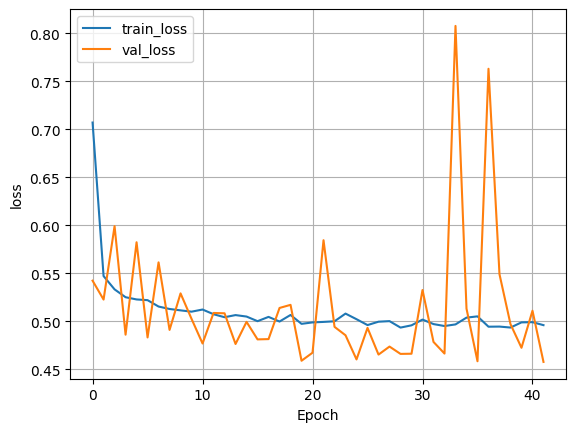

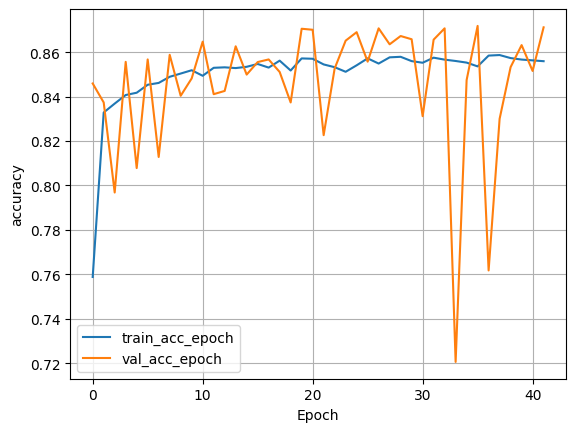

In [12]:
# enc_factor = 0.3
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
# enc_factor = 0
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
# enc_factor = 0.1
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
from typing import List
def find_best_settings(lrs: List[float]=[0.001], dropouts: List[float]=[0.2], weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], log_name='find_best_settings'):
    for lr in lrs:
        for dropout in dropouts:
            for wd in weight_decays:
                for emb_factor in emb_factors:
                    torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 64, dropout=dropout)
                    lightning_model = HeteroBinaryLightningModel(torch_model,
                                    torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
                                        loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
                                        learning_rate=lr,
                                        batch_size=batch_size,
                                        user_lr_scheduler=True
                                        ).to(device)
                    model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
                    print(model_manager.lightning_model.optimizer.)
                    model_manager.fit(datamodule=data_manager)
                    model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
lrs = [0.001]#np.logspace(-5,-2,10)
dropouts =  np.linspace(0.2, 0.6, 5)
weight_decays = [0.001]# np.logspace(-5,-2,10)
emb_factors = [0.185]#np.linspace(0.07, 0.3, 3)
find_best_settings(lrs, dropouts, weight_decays, emb_factors, log_name='find_dropout')

In [ ]:
model_manager.tune(data_manager=data_manager, min_lr=1e-10, max_lr=1e-2)

In [ ]:
# next(iter(model_manager.lightning_model.optimizer.param_groups))['lr']

In [ ]:
model_manager.fit(datamodule=data_manager)

In [ ]:
next(iter(model_manager.lightning_model.optimizer.param_groups))['lr']

In [ ]:
model_manager.lightning_model.update_learning_rate(0.003)

In [ ]:
model_manager.fit(datamodule=data_manager)

In [ ]:
model_manager.trainer.checkpoint_callback.best_model_path

In [ ]:
model_manager.plot_csv_logger()

In [ ]:
model_manager.lightning_model.optimizer.param_groups

In [ ]:
for p in model_manager.lightning_model.model.parameters():
    print(p)

In [ ]:
next(iter(model_manager.lightning_model.optimizer.param_groups))

In [ ]:
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=500,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='hetero_gnn_1'),
            num_sanity_val_steps=0)

In [ ]:
tuner = Tuner(trainer)
results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.0000001,max_lr=0.1)


In [ ]:
fig = results.plot(suggest=True)

In [ ]:
# next(iter(trainer.model.optimizer.param_groups))

In [ ]:
trainer.fit(model=lightning_model, datamodule=data_manager)

In [ ]:
trainer.checkpoint_callback.best_model_path

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from os import path
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)

    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()

In [ ]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\hetero_model_2\version_47\metrics.csv', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])